# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Наша задача — установить параметры, которые влияют на рыночную стоимость объектов недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Цель** - установить параметры, которые помогут определить рыночную цену квартиры в автоматизированной системе 


**Ход исследования:**
* оценить данные   
* заполнить пропуски   
* удалить дубликаты, выбросы   
* оценить влияние показателей на стоимость квартиры
* выбрать лучшие параметры для модели

### Знакомство с данными

In [ ]:
#загружаем необходимые библиотеки
!pip install pandas

import pandas as pd
import numpy as np

import warnings

warnings.filterwarnings('ignore')

In [2]:
#загружаем датасет
try:
    data = pd.read_csv('/datasets/real_estate_data.csv',  sep="\t")
except:
    data = pd.read_csv('/Users/amirk/Downloads/real_estate_data.csv',  sep="\t")

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

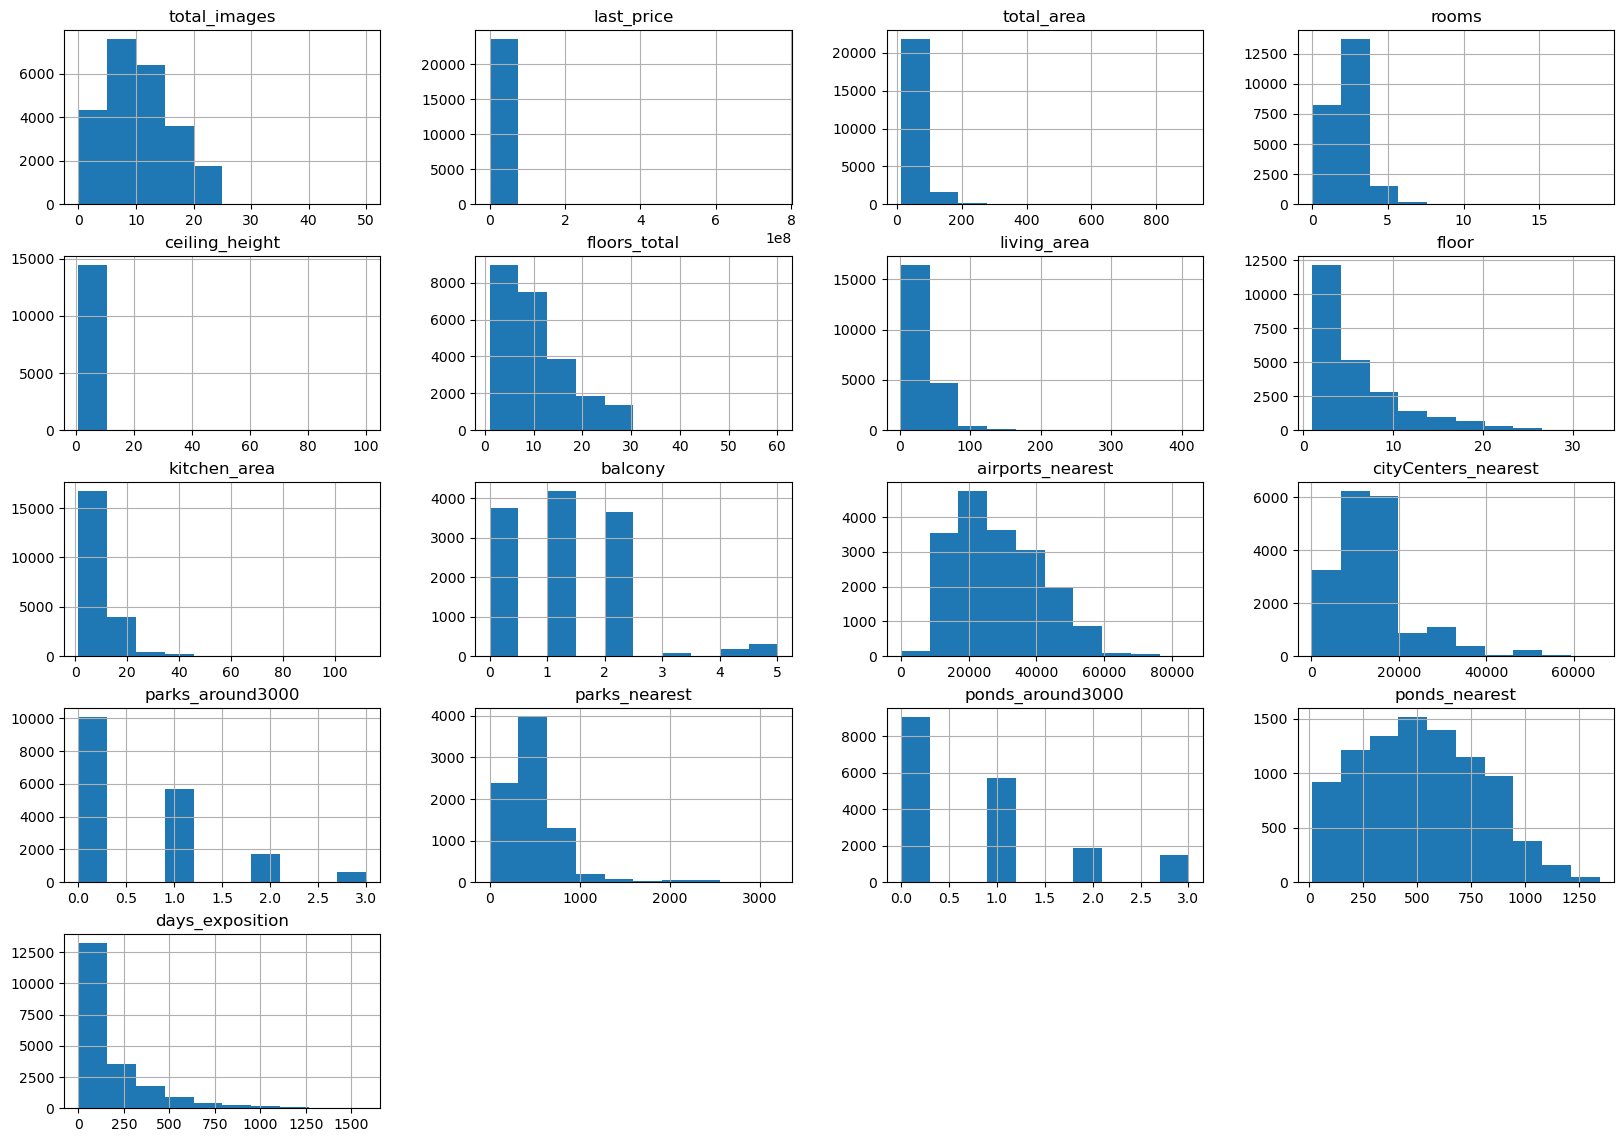

In [5]:
data.hist(figsize=(20, 14));

**Первые впечатления о данных**
* в некоторых столбцах очень много пропусков, возможно где-то они логичны
* гистограммы на первый взгляд достаточно логично отражают данные

### Предобработка данных

#### Заполнение пропусков
**Определим в каких столбцах есть пропуски.**

In [6]:
data.isna().sum() 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Начнем просматривать все подряд столбцы с пропусками и постараемся заполнить все возможные пропуски**

In [7]:
print(data['ceiling_height'].sort_values().unique())
data['ceiling_height'].describe()

[  1.     1.2    1.75   2.     2.2    2.25   2.3    2.34   2.4    2.45
   2.46   2.47   2.48   2.49   2.5    2.51   2.52   2.53   2.54   2.55
   2.56   2.57   2.58   2.59   2.6    2.61   2.62   2.63   2.64   2.65
   2.66   2.67   2.68   2.69   2.7    2.71   2.72   2.73   2.74   2.75
   2.76   2.77   2.78   2.79   2.8    2.81   2.82   2.83   2.84   2.85
   2.86   2.87   2.88   2.89   2.9    2.91   2.92   2.93   2.94   2.95
   2.96   2.97   2.98   2.99   3.     3.01   3.02   3.03   3.04   3.05
   3.06   3.07   3.08   3.09   3.1    3.11   3.12   3.13   3.14   3.15
   3.16   3.17   3.18   3.2    3.21   3.22   3.23   3.24   3.25   3.26
   3.27   3.28   3.29   3.3    3.31   3.32   3.33   3.34   3.35   3.36
   3.37   3.38   3.39   3.4    3.42   3.43   3.44   3.45   3.46   3.47
   3.48   3.49   3.5    3.51   3.52   3.53   3.54   3.55   3.56   3.57
   3.58   3.59   3.6    3.62   3.63   3.65   3.66   3.67   3.68   3.69
   3.7    3.75   3.76   3.78   3.8    3.82   3.83   3.84   3.85   3.86
   3.8

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

В `ceiling_height` среднее значение и медиана в целом достаточно близки друг к другу, поэтому пустые значения можно было бы заменить медианой. Также тут много неправдоподобных значений, вряд ли есть квартиры с потолками более 5 метров. Проверим, есть ли корреляция высоты потолка с каким либо значением.

In [8]:
data.corr()['ceiling_height']

total_images          -0.001987
last_price             0.085430
total_area             0.095490
rooms                  0.054457
ceiling_height         1.000000
floors_total          -0.028732
living_area            0.090650
floor                 -0.011798
studio                 0.001674
open_plan              0.042777
kitchen_area           0.087641
balcony                0.040523
airports_nearest      -0.023947
cityCenters_nearest   -0.091689
parks_around3000       0.065915
parks_nearest         -0.019167
ponds_around3000       0.078209
ponds_nearest         -0.059090
days_exposition        0.019091
Name: ceiling_height, dtype: float64

**Высокий коэффициент корреляции не выявлен, поэтому заменим пропуски медианным значением по всем объявлениям.**

In [9]:
data.loc[data['ceiling_height'].isna() == True, 'ceiling_height'] = data['ceiling_height'].median()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [10]:
# посмотрим столбец floors_total
print(data['floors_total'].sort_values().unique())
data['floors_total'].describe()

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 33. 34. 35. 36. 37. 52. 60.
 nan]


count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

**Можно было бы предположить, что общее количество этажей не указано, так как всего один этаж. 
Проверим на каком этаже находятся квартиры, где не указано общее количество этажей.**

In [11]:
data[data['floors_total'].isna()]['floor'].unique()

array([ 4,  1, 12,  8,  9, 22, 15,  6,  7,  3, 18, 13, 24, 21, 11,  2,  5,
       19, 20, 14, 17, 23, 10], dtype=int64)

**Заменять `NaN` в `flors_total` на `1` нельзя!**

In [12]:
# посмотрим столбец living_area
print(data['living_area'].isna().sum())
data['living_area'].describe()

1903


count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

Проверим наличие корреляции между жилой площадью и другими показателями.

In [13]:
data.corr()['living_area']

total_images           0.104780
last_price             0.566492
total_area             0.939537
rooms                  0.845977
ceiling_height         0.078623
floors_total          -0.169311
living_area            1.000000
floor                 -0.097210
studio                -0.056231
open_plan             -0.033711
kitchen_area           0.428674
balcony                0.018849
airports_nearest      -0.057912
cityCenters_nearest   -0.231368
parks_around3000       0.184453
parks_nearest         -0.050167
ponds_around3000       0.148933
ponds_nearest         -0.081674
days_exposition        0.142454
Name: living_area, dtype: float64

**Выявлена высокая корреляционная связь с общей площадью и количеством комнат. В данном случае пропуски жилой площади можно заполнить медианными значениями в зависимости от количества комнат.**

In [14]:
for i in data['rooms'].unique():
    data.loc[(data['living_area'].isna() == True) & (data['rooms'] == i), 'living_area'] = data.loc[(data['living_area'].isna() == False) & (data['rooms'] == i), 'living_area'].median()
data['living_area'].isna().sum() 

0

**У нас получилось заполнить все пропуски!!!**

In [15]:
# посмотрим столбец is_apartment
print(data['is_apartment'].unique())


[nan False True]


Можно предположить, что пропуски возникли там где, должно было быть **False**. Можно сравнить средние площади квартир, если наше предположение верно, то площадь квартир со значениями **NaN** и **False** должны быть схожи, и в то же время меньше **True**, потому что апартаменты это жилье с большой площадью.

In [16]:
data['is_apartment'] = data['is_apartment'].fillna('research_group')
data.pivot_table(index='is_apartment', values=('total_area', 'living_area'), aggfunc=('mean', 'median'))

living_area        total_area       
                      mean median       mean median
is_apartment                                       
False            34.916349  30.90  61.123761   54.0
True             47.536800  31.25  83.325800   64.0
research_group   34.212997  30.20  60.192800   52.0

Значения общей и жилой площади в подгруппах **False** и **research_group** очень похожи. Исходя из этого можем считать, что пропущенные значения означают `False`. Заполним пропущенные значения.

In [17]:
data['is_apartment'] = data['is_apartment'].where(data['is_apartment'] != 'research_group', False)
data['is_apartment'].unique()

array([False, True], dtype=object)

**Замена произведена правильно!**

In [18]:
# посмотрим столбец kitchen_area
print(data['kitchen_area'].isna().sum())
data['kitchen_area'].describe()

2278


count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Проверим наличие корреляции между площадью кухни и другими показателями.

In [19]:
data.corr()['kitchen_area']

total_images           0.104756
last_price             0.519869
total_area             0.609121
rooms                  0.269945
ceiling_height         0.071350
floors_total           0.163944
living_area            0.423638
floor                  0.135531
studio                      NaN
open_plan                   NaN
kitchen_area           1.000000
balcony                0.098634
airports_nearest       0.008200
cityCenters_nearest   -0.190049
parks_around3000       0.087503
parks_nearest          0.029641
ponds_around3000       0.150148
ponds_nearest         -0.105223
days_exposition        0.100586
Name: kitchen_area, dtype: float64

**Высокой корреляционной связи мы не выявили, поэтому будем заполнять пропуски медианным значением для всех объявлений.**

In [20]:
data.loc[data['kitchen_area'].isna() == True, 'kitchen_area'] = data['kitchen_area'].median()
data['kitchen_area'].isna().sum()

0

**Все пропуски заменены!**

In [21]:
# посмотрим столбец balcony
print(data['balcony'].sort_values().unique())

[ 0.  1.  2.  3.  4.  5. nan]


Скорее всего пользователи забыли указать `0`, поэтому появились пропуски. 

In [22]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].sort_values().unique()

array([0., 1., 2., 3., 4., 5.])

**Замена произведена правильно!**

In [23]:
# посмотрим столбец locality_name
print(data['locality_name'].unique())
print('Количество уникальных названий:', len(data['locality_name'].unique()))
print(data.duplicated().sum())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

**Явных дубликатов** в датасете - нет!
**Неявные дубликаты** связаны с написанием "поселок" и "посёлок", а также в различных написаниях "поселок" и "поселок городского типа". Попробуем утранить данные дубликаты.

In [24]:
for i in data['locality_name'].unique():
    data.loc[data['locality_name'] == i, 'locality_name'] = str(i).replace('посёлок', 'поселок')
for i in data['locality_name'].unique(): #пишем еще одну функцию, потому что если делать в одной, то возвращается буква Ё
    clear_locality_name = str(i).split(sep=' ')[-1] # находим непосредственное название места, оно всегда стоит последним в названии
    data.loc[data['locality_name'].str.contains(clear_locality_name) == True, 'locality_name'] = i
print(data['locality_name'].sort_values().unique())
print('Количество уникальных названий:', len(data['locality_name'].unique()))


['Бокситогорск' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Высоцк'
 'Гатчина' 'Зеленогорск' 'Ивангород' 'Каменногорск' 'Кингисепп' 'Кириши'
 'Кировск' 'Колпино' 'Коммунар' 'Красное Село' 'Кронштадт' 'Кудрово'
 'Лодейное Поле' 'Ломоносов' 'Луга' 'Мурино' 'Отрадное' 'Павловск'
 'Петергоф' 'Пикалёво' 'Подпорожье' 'Приморск' 'Приозерск' 'Пушкин'
 'Санкт-Петербург' 'Сертолово' 'Сестрорецк' 'Сланцы' 'Сясьстрой' 'Тихвин'
 'Тосно' 'Шлиссельбург' 'городской поселок Будогощь'
 'городской поселок Виллози' 'городской поселок Новоселье'
 'городской поселок Рощино' 'городской поселок Советский'
 'городской поселок Фёдоровское' 'городской поселок Янино-1'
 'деревня Агалатово' 'деревня Аро' 'деревня Батово' 'деревня Белогорка'
 'деревня Большая Вруда' 'деревня Большая Пустомержа'
 'деревня Большое Рейзино' 'деревня Большой Сабск' 'деревня Ваганово'
 'деревня Вартемяги' 'деревня Вахнова Кара' 'деревня Выскатка'
 'деревня Глинка' 'деревня Горбунки' 'деревня Гостилицы'
 'деревня Заклинье' 'деревня Заневк

**Мы избавились от неявных дубликатов! Почти на треть сократилось количество уникальных названий населенных пунктов!!!**  

In [25]:
# посмотрим столбец airports_nearest
print(data['airports_nearest'].isna().sum())
data['airports_nearest'].describe()

5542


count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [26]:
airports_stat = data.pivot_table(index='locality_name', values='airports_nearest', aggfunc='median').reset_index()
print(airports_stat)

                            locality_name  airports_nearest
0                             Зеленогорск           72282.0
1                                 Колпино           26232.0
2                            Красное Село           25715.5
3                               Кронштадт           67850.0
4                               Ломоносов           48415.5
5                                  Мурино           51553.0
6                                Павловск           20529.5
7                                Петергоф           39231.0
8                                  Пушкин           15766.0
9                         Санкт-Петербург           26757.5
10                             Сестрорецк           56692.0
11                        деревня Щеглово           61908.0
12                поселок Александровская           12896.5
13                     поселок Белоостров           57769.0
14                       поселок Левашово           52693.0
15                      поселок Лисий Но

**Видим медиану расстояния до аэропорта для некоторых населенных пунктов, для остальных данные вообще не указаны. 
Теперь можем этими значениями заполнить часть имеющихся пропусков.**

In [27]:
locality_name_unique = airports_stat['locality_name'].unique()
print('Количество пропусков до заполнения:', data['airports_nearest'].isna().sum())
for i in locality_name_unique:
    data.loc[(data['locality_name'] == i) & (data['airports_nearest'].isna() == True),'airports_nearest'] = data.loc[(data['locality_name'] == i) & (data['airports_nearest'].isna() == True),'airports_nearest'].fillna(float(airports_stat.loc[airports_stat['locality_name'] == i, 'airports_nearest']))
print('Количество пропусков после заполнения:', data['airports_nearest'].isna().sum())

Количество пропусков до заполнения: 5542
Количество пропусков после заполнения: 4820


**От части пропусков избавились! +1 к карме) Идем дальше...**

In [28]:
# посмотрим столбец cityCenters_nearest
# сначала изменим его название на змеиный регистр
data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}, inplace=True)
print(data['city_centers_nearest'].describe())
data['city_centers_nearest'].isna().sum()

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64


5519

In [29]:
#для заполнения пропусков сделаем аналогичные действия как в прошлом столбце
centers_stat = data.pivot_table(index='locality_name', values='city_centers_nearest', aggfunc='median').reset_index()
locality_name_unique_cent = centers_stat['locality_name'].unique()
print('Количество пропусков до заполнения:', data['city_centers_nearest'].isna().sum())
for i in locality_name_unique_cent:
    data.loc[(data['locality_name'] == i) & (data['city_centers_nearest'].isna() == True),'city_centers_nearest'] = data.loc[(data['locality_name'] == i) & (data['city_centers_nearest'].isna() == True),'city_centers_nearest'].fillna(float(centers_stat.loc[centers_stat['locality_name'] == i, 'city_centers_nearest']))
print('Количество пропусков после заполнения:', data['city_centers_nearest'].isna().sum())

Количество пропусков до заполнения: 5519
Количество пропусков после заполнения: 4820


**Идем дальше! Прослеживается какая-то закономерность - отдаленность от аэропорта и до центра отсутсвует в одинаковом количестве населенных пунктов.**

In [30]:
# следующий столбец parks_around3000
print(data['parks_around3000'].isna().sum())
data['parks_around3000'].describe()

5518


count    18181.000000
mean         0.611408
std          0.802074
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

In [31]:
#для заполнения пропусков сделаем аналогичные действия как в прошлом столбце
parks_around_stat = data.pivot_table(index='locality_name', values='parks_around3000', aggfunc='median').reset_index()
locality_name_unique_parks_around = parks_around_stat['locality_name'].unique()
print('Количество пропусков до заполнения:', data['parks_around3000'].isna().sum())
for i in locality_name_unique_parks_around:
    data.loc[(data['locality_name'] == i) & (data['parks_around3000'].isna() == True),'parks_around3000'] = data.loc[(data['locality_name'] == i) & (data['parks_around3000'].isna() == True),'parks_around3000'].fillna(round(float(parks_around_stat.loc[parks_around_stat['locality_name'] == i, 'parks_around3000']), 0))
print('Количество пропусков после заполнения:', data['parks_around3000'].isna().sum())

Количество пропусков до заполнения: 5518
Количество пропусков после заполнения: 4820


Опять схожая цифра. Вероятно это проблема картографических данных. В небольших населенных пунктах может просто не быть центра города, аэропорта и парков. 

In [32]:
# следующий столбец park_nearest
# здесь очень много пропусков, нужно подробнее разобраться
print(data['parks_nearest'].isna().sum())
data['parks_nearest'].describe()

15620


count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [33]:
#для начала заполним пропуски как и раньше
parks_nearest_stat = data.pivot_table(index='locality_name', values='parks_nearest', aggfunc='median').reset_index()
locality_name_unique_parks_nearest = parks_nearest_stat['locality_name'].unique()
print('Количество пропусков до заполнения:', data['parks_nearest'].isna().sum())
for i in locality_name_unique_parks_nearest:
    data.loc[(data['locality_name'] == i) & (data['parks_nearest'].isna() == True),'parks_nearest'] = data.loc[(data['locality_name'] == i) & (data['parks_nearest'].isna() == True),'parks_nearest'].fillna(float(parks_nearest_stat.loc[parks_nearest_stat['locality_name'] == i, 'parks_nearest']))
print('Количество пропусков после заполнения:', data['parks_nearest'].isna().sum())

Количество пропусков до заполнения: 15620
Количество пропусков после заполнения: 6032


Количество пропусков **6032**, но мы помним, что число объявлений, где неизвестно наличие парков в радиусе 3000м, равно **4864**.
Посмотрим, какие значения стоят для этих объявлений с столбце `parks_around300`



In [34]:
data.loc[(data['parks_around3000'].isna() == False) & (data['parks_nearest'].isna() == True)]['parks_around3000'].unique()

array([0.])

Вот и причина. Пропуски обусловлены тем, что просто нет парков поблизости.

In [35]:
# следующий столбец parks_around3000
print(data['ponds_around3000'].isna().sum())
data['ponds_around3000'].describe()

5518


count    18181.000000
mean         0.770255
std          0.938346
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

In [36]:
#для заполнения пропусков сделаем аналогичные действия как в прошлом столбце
ponds_around_stat = data.pivot_table(index='locality_name', values='ponds_around3000', aggfunc='median').reset_index()
locality_name_unique_ponds_around = ponds_around_stat['locality_name'].unique()
print('Количество пропусков до заполнения:', data['ponds_around3000'].isna().sum())
for i in locality_name_unique_ponds_around:
    data.loc[(data['locality_name'] == i) & (data['ponds_around3000'].isna() == True),'ponds_around3000'] = data.loc[(data['locality_name'] == i) & (data['ponds_around3000'].isna() == True),'ponds_around3000'].fillna(round(float(ponds_around_stat.loc[ponds_around_stat['locality_name'] == i, 'ponds_around3000']), 0))
print('Количество пропусков после заполнения:', data['ponds_around3000'].isna().sum())

Количество пропусков до заполнения: 5518
Количество пропусков после заполнения: 4820


In [37]:
# следующий столбец ponds_nearest
# скорее всего логика появления пропусков будет такая же, как в 'park_nearest'. Проверим.
print(data['ponds_nearest'].isna().sum())
data['ponds_nearest'].describe()

14589


count    9110.000000
mean      517.980900
std       277.720643
min        13.000000
25%       294.000000
50%       502.000000
75%       729.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

In [38]:
#заполним пропуски как и раньше
ponds_nearest_stat = data.pivot_table(index='locality_name', values='ponds_nearest', aggfunc='median').reset_index()
locality_name_unique_ponds_nearest = ponds_nearest_stat['locality_name'].unique()
print('Количество пропусков до заполнения:', data['ponds_nearest'].isna().sum())
for i in locality_name_unique_ponds_nearest:
    data.loc[(data['locality_name'] == i) & (data['ponds_nearest'].isna() == True),'ponds_nearest'] = data.loc[(data['locality_name'] == i) & (data['ponds_nearest'].isna() == True),'ponds_nearest'].fillna(float(ponds_nearest_stat.loc[ponds_nearest_stat['locality_name'] == i, 'ponds_nearest']))
print('Количество пропусков после заполнения:', data['ponds_nearest'].isna().sum())

Количество пропусков до заполнения: 14589
Количество пропусков после заполнения: 4962


In [39]:
data.loc[(data['ponds_around3000'].isna() == False) & (data['ponds_nearest'].isna() == True)]['ponds_around3000'].unique()

array([0.])

**Пропуски так же обусловлены тем, что нет прудов поблизости.**

In [40]:
# следующий столбец days_exposition
print(data['days_exposition'].isna().sum())
data['days_exposition'].describe()

3181


count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

**Данный показатель скорее всего считается автоматически. Поэтому ошибок быть не должно. Скорее всего данные объявления на день выгрузки датасета еще были активными. День выгрузки данных мы не знаем, поэтому заполнить эти данные вряд ли получится. Но можно попробовать посмотреть корреляцию с другими показателями и попробовать заполнить медианными значениями в зависимости от выявленных связей**

In [41]:
data.corr()['days_exposition']

total_images           -0.026657
last_price              0.081146
total_area              0.149675
rooms                   0.126961
ceiling_height          0.018142
floors_total           -0.052234
living_area             0.140794
floor                  -0.039463
studio                 -0.022476
open_plan              -0.024112
kitchen_area            0.100991
balcony                -0.027834
airports_nearest       -0.026779
city_centers_nearest   -0.065032
parks_around3000        0.063428
parks_nearest           0.015274
ponds_around3000        0.064185
ponds_nearest          -0.045077
days_exposition         1.000000
Name: days_exposition, dtype: float64

**Никаких корреляционных связей мы не нашли, среднее и медиана очень различаются, поэтому пропуски заполнить не получится**

**Проверим сколько пропусков данных в датасете сейчас**

In [42]:
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total              86
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name             49
airports_nearest        4820
city_centers_nearest    4820
parks_around3000        4820
parks_nearest           6032
ponds_around3000        4820
ponds_nearest           4962
days_exposition         3181
dtype: int64

**Небольшие промежуточные выводы**
* Удалость избавиться от части пропусков
* Пропуски возникали как по вине пользователей, так и картографических сервисов.
* Часть пропусков можно заполнить, запросив информацию у заказчика.

#### Изменение типов данных

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Вызывают вопрос следующие столбцы:**
* first_day_exposition - показывает время (datetime)
* floors_total - целое число
* is_apartment - булевое значение
* balcony - целое число
* parks_around3000 - целое число
* ponds_around3000 - целое число
* days_exposition - целое число

**Приступим к смене типов данных в указанных столбцах**

In [44]:
def change_type_num(column):
    data.loc[data[column].isna() == True, column] = -1 
    data[column] = data[column].astype('int') 
    data.loc[data[column] == -1, column] = pd.NA 
    data[column] = data[column].astype('Int64') #данный формат int может содержать NaN 
       
for column in ['last_price','floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']:
    change_type_num(column)

# теперь изменим формат first_day_exposition
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

# и наконец изменим столбец is_apartment на булевые значения
data['is_apartment'] = data['is_apartment'].astype('bool')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  Int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  Int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

**Все наши запланированные изменения типов данных выполнены!**
Нам необходимо было изменить типы данных, чтобы дальнейшие рассчеты с целыми числами были правильными, ячейка с датой и временем необходимы для возможности работы с датой и временем.

#### Выбросы в данных
Начнем перебирать все столбцы подряд (кроме булевых и строковых) и оценивать редкие значения и выбросы.


count    23699.000000
mean         9.858475
std          5.682529
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64

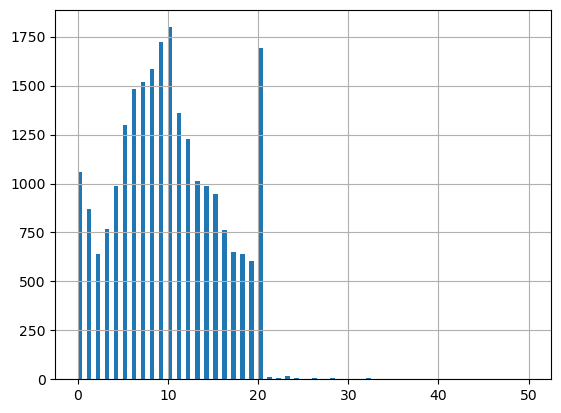

In [45]:
data['total_images'].hist(bins=100)
data['total_images'].describe()

Видно, что значения более 20 встречаются крайне редко. Можем их принять за редкие и удалить

In [46]:
good_data = data.query('total_images <= 20')

count     23699.000000
mean       6541.548772
std       10887.013268
min          12.190000
25%        3400.000000
50%        4650.000000
75%        6800.000000
max      763000.000000
Name: last_price, dtype: float64

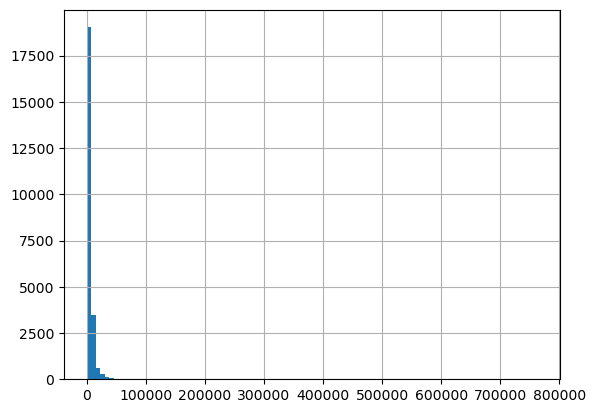

In [47]:
(data['last_price'] / 1000).hist(bins=100) #уменьшим цену в 1000 раз для лучшего восприятия цифр
(data['last_price'] / 1000).describe()

Видно, что значения более 20 млн встречаются крайне редко, однако могут вносить изменения в среднее. Можем их принять за редкие и удалить

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  Int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  Int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

In [49]:
good_data = data.query('last_price <= 20000000', engine='python')

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

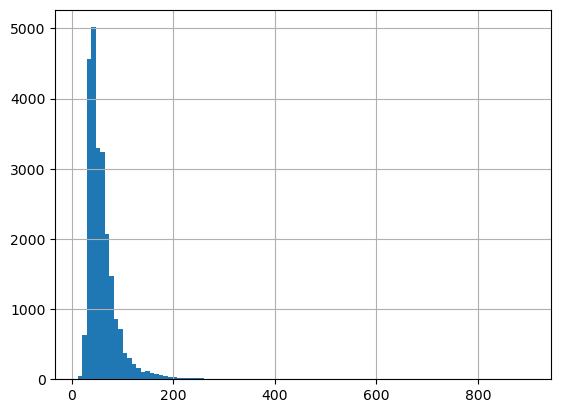

In [50]:
data['total_area'].hist(bins=100)
data['total_area'].describe()

Квартиры общей площадью более 200 метров встречаются к очень редко, удалим их из базы

In [51]:
good_data = good_data.query('total_area <= 200')

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

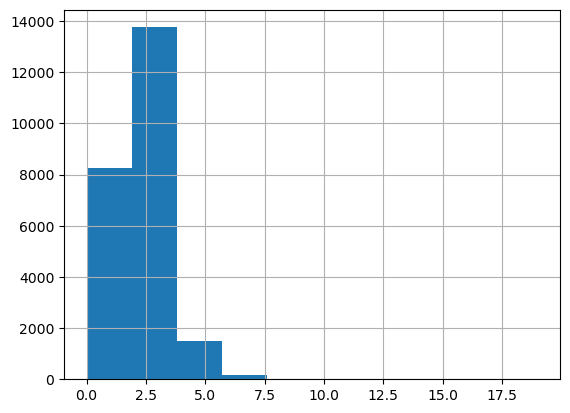

In [52]:
data['rooms'].hist(bins=10)
data['rooms'].describe()

Квартиры с количеством комнат более 6 встречаются к очень редко, удалим их из базы

In [53]:
good_data = good_data.query('rooms <= 6')

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

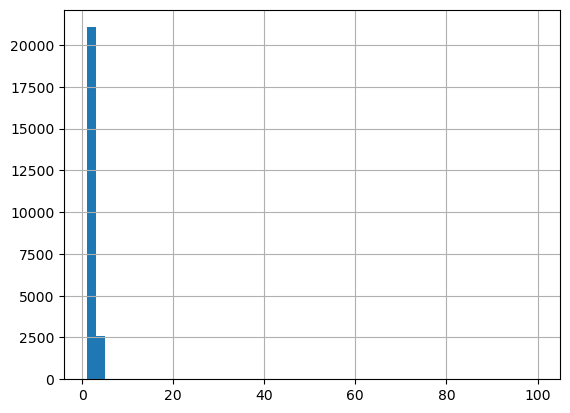

In [54]:
data['ceiling_height'].hist(bins=50)
data['ceiling_height'].sort_values().unique()

Высота потолков вряд ли может быть менее 2.2 и более 4 метров, поэтому удалим данные значения. Так же видно, что в данных прослеживается явные аномальные значения, увеличенные в 10 раз. Исправим данные ошибки.

<AxesSubplot:>

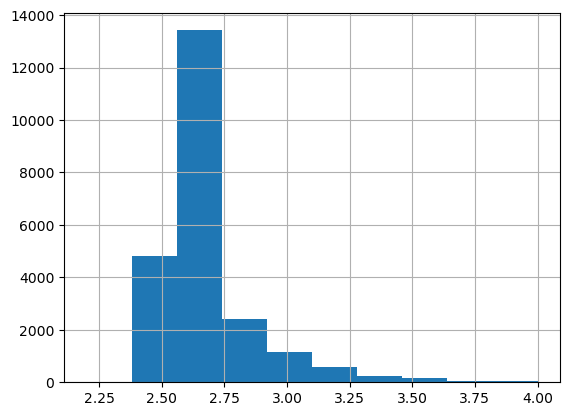

In [55]:
good_data.loc[good_data['ceiling_height'] > 10, 'ceiling_height'] = good_data.loc[good_data['ceiling_height'] > 10, 'ceiling_height'] / 10
good_data = good_data.query('2.2 <= ceiling_height <= 4')
good_data['ceiling_height'].hist()

<IntegerArray>
[   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,   12,   13,
   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,   24,   25,   26,
   27,   28,   29,   33,   34,   35,   36,   37,   52,   60, <NA>]
Length: 37, dtype: Int64
Количество пропусков в данном столбце: 86


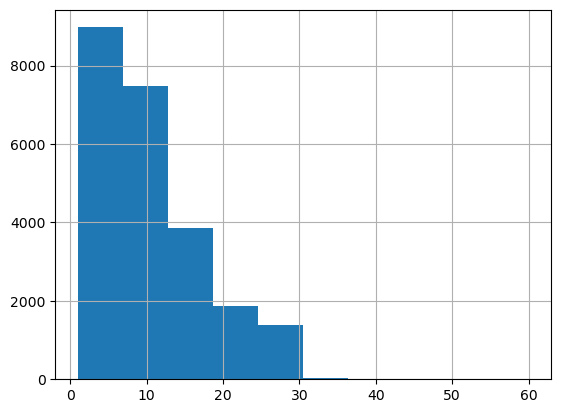

In [56]:
data['floors_total'].hist(bins=10)
print(data['floors_total'].sort_values().unique())
print('Количество пропусков в данном столбце:', data['floors_total'].isna().sum())

Количество объявлений, где количество этажей больше 30 очень мало, поэтому удалим эти редкие значения. 86 пропусков тоже удалим.

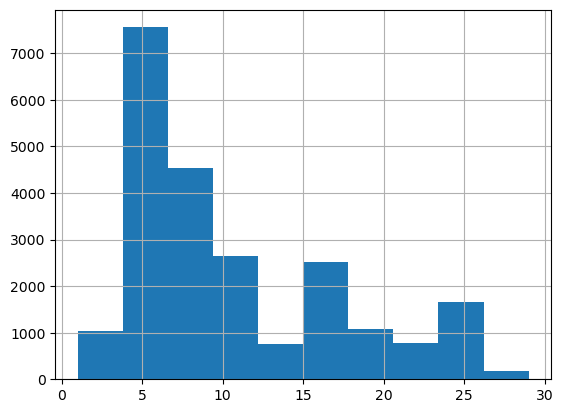

In [57]:
good_data = good_data.query('floors_total <= 30', engine='python')
good_data = good_data.dropna(subset=['floors_total'])
good_data['floors_total'].hist(bins=10);

count    23699.000000
mean        34.321982
std         21.700627
min          2.000000
25%         18.400000
50%         30.300000
75%         42.700000
max        409.700000
Name: living_area, dtype: float64

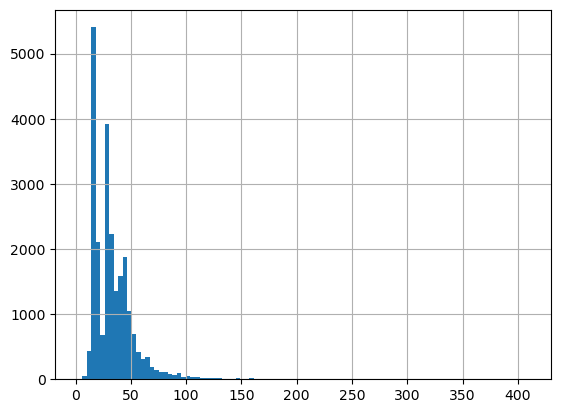

In [58]:
data['living_area'].hist(bins=100)
data['living_area'].describe()

Квартиры с жилой площадью более 100 метров встречаются редко, поэтому удалим данные значения

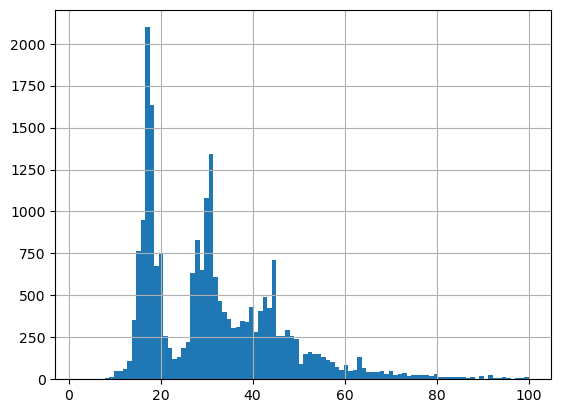

In [59]:
good_data = good_data.query('living_area <= 100')
good_data['living_area'].hist(bins=100);

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

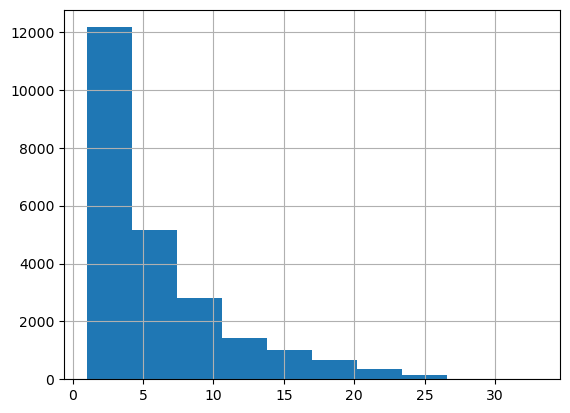

In [60]:
data['floor'].hist(bins=10)
data['floor'].describe()

Квартиры выше, чем на 25 этаже встречаются очень редко, удалим квартиры, которые выше.

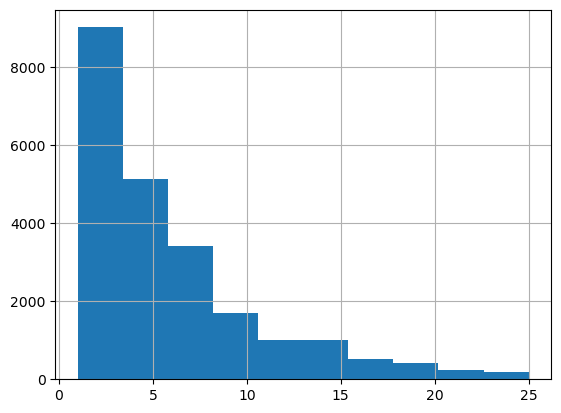

In [61]:
good_data = good_data.query('floor <= 25', engine='python')
good_data['floor'].hist(bins=10);

count    23699.000000
mean        10.428526
std          5.631126
min          1.300000
25%          7.400000
50%          9.100000
75%         11.440000
max        112.000000
Name: kitchen_area, dtype: float64

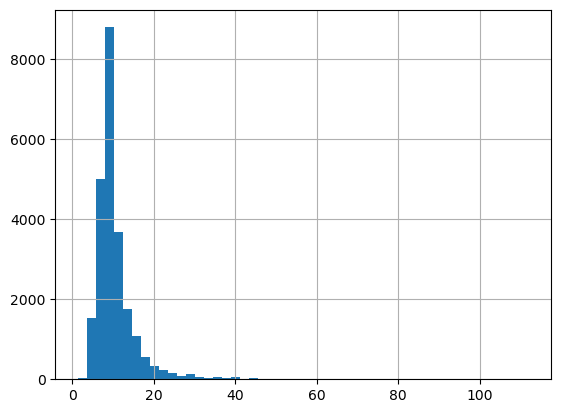

In [62]:
data['kitchen_area'].hist(bins=50)
data['kitchen_area'].describe()

Квартиры с кухней более 30 м встречаются очень редко, удалим квартиры, где площадь кухни больше.

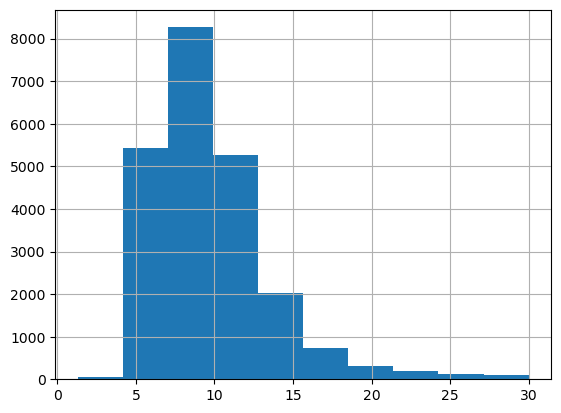

In [63]:
good_data = good_data.query('kitchen_area <= 30')
good_data['kitchen_area'].hist(bins=10);

count    23699.000000
mean         0.591080
std          0.959298
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64

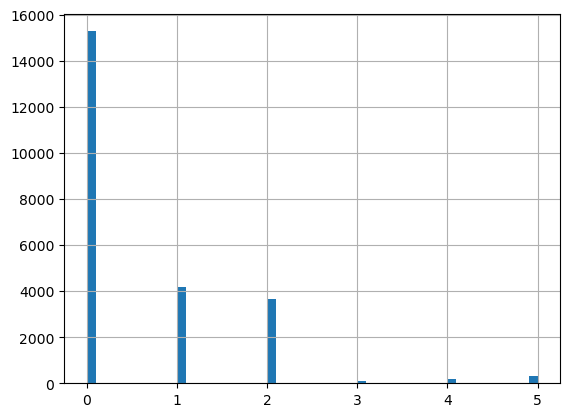

In [64]:
data['balcony'].hist(bins=50)
data['balcony'].describe()

В данном столбце данные удалять не будем, все распределено достаточно логично.

count    18879.000000
mean     29531.884978
std      13058.166108
min          0.000000
25%      18849.000000
50%      27166.000000
75%      38743.000000
max      84869.000000
Name: airports_nearest, dtype: float64

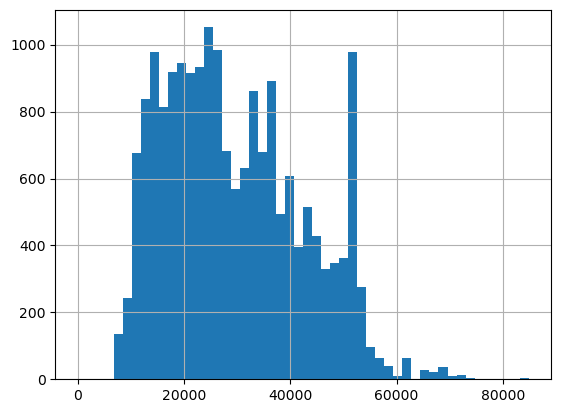

In [65]:
data['airports_nearest'].hist(bins=50)
data['airports_nearest'].describe()

Данные менять не будем!Пик на графике в районе 50 км вероятно обусловлен тем, что на данном растоянии от аэропорта находится крупный город с большим количеством объявлений.

count    18879.000000
mean     14470.817125
std       8603.005124
min        181.000000
25%       9488.500000
50%      13270.000000
75%      16786.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

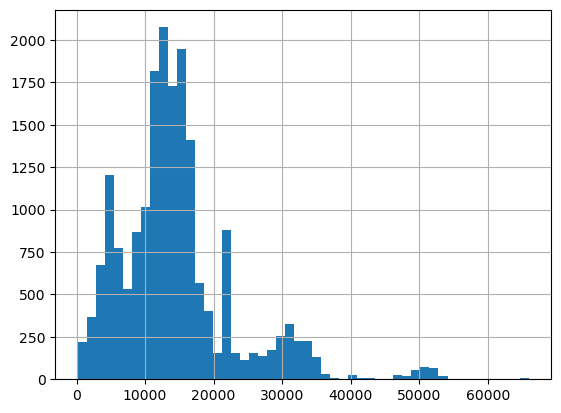

In [66]:
data['city_centers_nearest'].hist(bins=50)
data['city_centers_nearest'].describe()

Значения более 55000 м встречаются крайне редко, удалим их. Пропуски пока оставим!

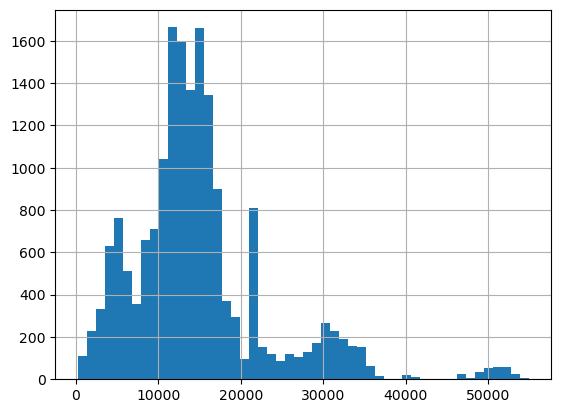

In [67]:
good_data = good_data.query('(city_centers_nearest <= 55000) | (city_centers_nearest.isna() == True)')
good_data['city_centers_nearest'].hist(bins=50);

count    18879.000000
mean         0.588908
std          0.795571
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

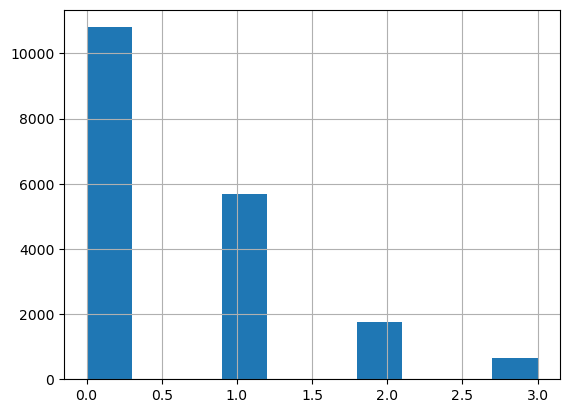

In [68]:
data['parks_around3000'].hist(bins=10)
data['parks_around3000'].describe()

Все выглядит правильно, удалять ничего не будем.

count    17667.000000
mean       475.966972
std        235.604308
min          1.000000
25%        428.500000
50%        460.000000
75%        460.000000
max       3190.000000
Name: parks_nearest, dtype: float64

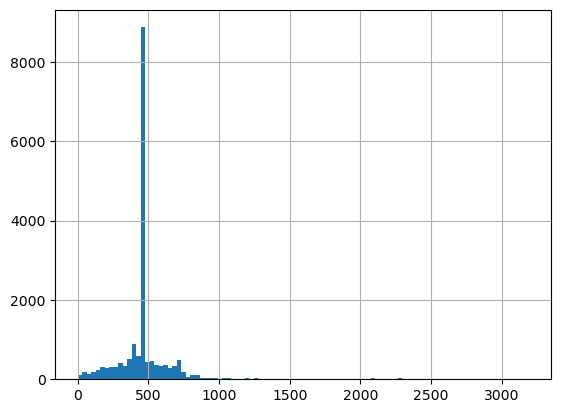

In [69]:
data['parks_nearest'].hist(bins=100)
data['parks_nearest'].describe()

Значения более 750м стречаются крайне редко, удалим их.

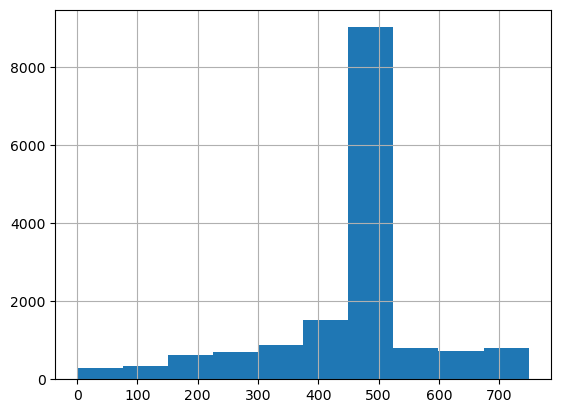

In [70]:
good_data = good_data.query('(parks_nearest <= 750) | (parks_nearest.isna() == True)')
good_data['parks_nearest'].hist(bins=10);

Нужно проверить предположение, что в некоторых объявлениях, где количество парков в радиусе 3000м равно 0, данный показатель тоже могли оценить как 0. Если это так, то нужно удалить нулевые значения, где количество парков в радиусе 3000м равно 0.

In [71]:
good_data.loc[(good_data['parks_around3000'] == 0) & (good_data['parks_nearest'] == 0), 'parks_around3000'].count()

0

Таких объявлений нет, все в порядке!

count    18879.000000
mean         0.807511
std          0.946232
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

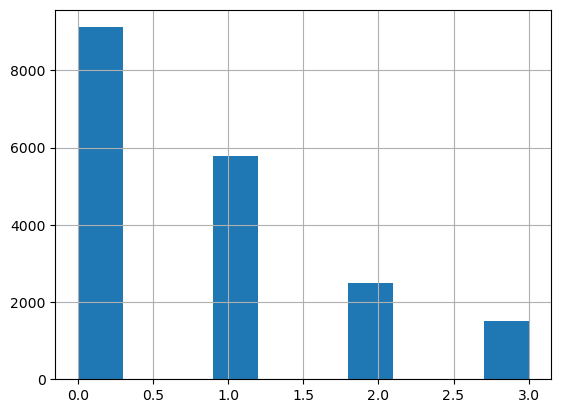

In [72]:
data['ponds_around3000'].hist(bins=10)
data['ponds_around3000'].describe()

Все выглядит правильно, удалять ничего не будем.

count    18737.000000
mean       498.223035
std        207.477420
min         13.000000
25%        441.000000
50%        503.000000
75%        552.000000
max       1344.000000
Name: ponds_nearest, dtype: float64

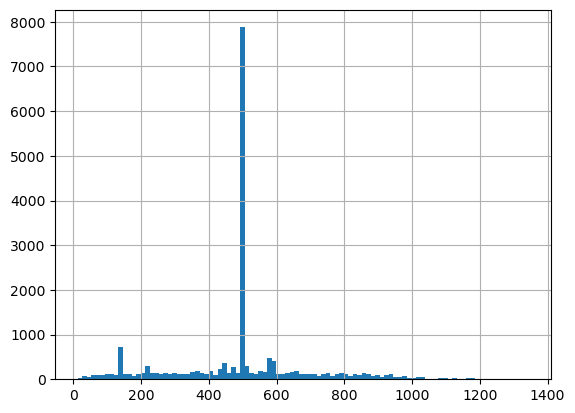

In [73]:
data['ponds_nearest'].hist(bins=100)
data['ponds_nearest'].describe()

Значения более 1000м стречаются крайне редко, удалим их.

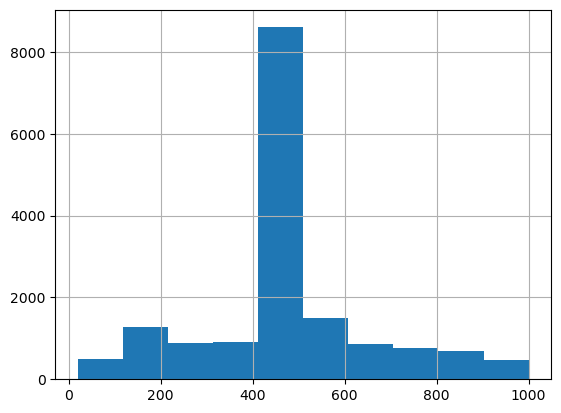

In [74]:
good_data = good_data.query('(ponds_nearest <= 1000) | (ponds_nearest.isna() == True)')
good_data['ponds_nearest'].hist(bins=10);

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

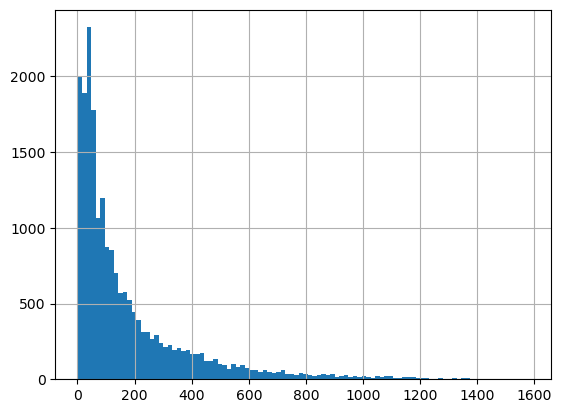

In [75]:
data['days_exposition'].hist(bins=100)
data['days_exposition'].describe()

Значения более 800 всречаются редко, поэтому удалим их.

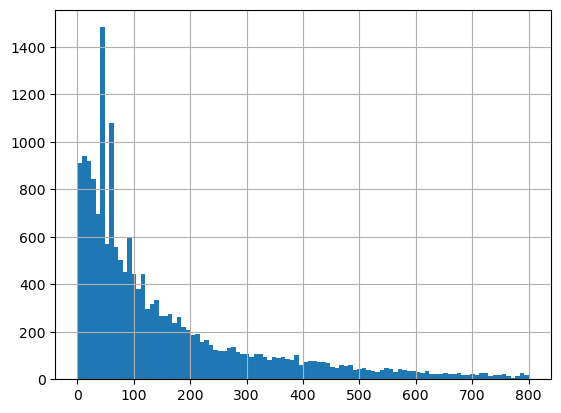

In [76]:
good_data = good_data.query('(days_exposition <= 800) | (days_exposition.isna() == True)', engine='python')
good_data['days_exposition'].hist(bins=100);

**Проверим, что теперь стало с нашим обновленным датасетом**

In [77]:
good_data.info()
good_data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20888 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20888 non-null  int64         
 1   last_price            20888 non-null  Int64         
 2   total_area            20888 non-null  float64       
 3   first_day_exposition  20888 non-null  datetime64[ns]
 4   rooms                 20888 non-null  int64         
 5   ceiling_height        20888 non-null  float64       
 6   floors_total          20888 non-null  Int64         
 7   living_area           20888 non-null  float64       
 8   floor                 20888 non-null  int64         
 9   is_apartment          20888 non-null  bool          
 10  studio                20888 non-null  bool          
 11  open_plan             20888 non-null  bool          
 12  kitchen_area          20888 non-null  float64       
 13  balcony         

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name             45
airports_nearest        4690
city_centers_nearest    4690
parks_around3000        4690
parks_nearest           5845
ponds_around3000        4690
ponds_nearest           4821
days_exposition         2730
dtype: int64

**Промежуточные выводы**
* Данные очищены от большого количества пропусков, возникших из-за ошибок пользователей. Остались пропуски в картографических данных, которые можно запросить у заказчика, для получения более точных результатов.
* Мы избавились от неявных дубликатов в столбце с названиями населенных пунктов
* Мы очистили данные от выбросов и явных ошибок

### Добавление новых столбцов

Добавим новые столбцы в таблицу согласно инструкции

In [78]:
#цена одного квадратного метра
good_data['sq_meter_price'] = (good_data['last_price'] / good_data['total_area'])

#день недели публикации объявления 
good_data['week_day'] = good_data['first_day_exposition'].dt.weekday

#месяц публикации объявления
good_data['month'] = good_data['first_day_exposition'].dt.month

#год публикации объявления
good_data['year'] = good_data['first_day_exposition'].dt.year

#тип этажа квартиры (значения — «первый», «последний», «другой»)
def floor_type(row):
    try:
        if row['floor'] == 1:
            return 'первый'
        if 1 < row['floor'] < row['floors_total']:
            return 'другой'
        if row['floor'] == row['floors_total']:
            return 'последний'
    except:
        pass
good_data['floor_type'] = good_data.apply(floor_type, axis=1)

#расстояние до центра города в километрах
good_data['city_centers_nearest_km'] = (good_data['city_centers_nearest'] / 1000).round(0)

good_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,week_day,month,year,floor_type,city_centers_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2,755.0,<NA>,120370.37037,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,0,584.5,81,82920.792079,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,90.0,2,574.0,558,92785.714286,3,8,2015,другой,14.0
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,<NA>,NaN,55,95065.789474,0,9,2018,другой,NaN
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.6,6,False,...,733.0,0,593.0,155,99195.710456,3,11,2017,другой,19.0


**Все необходимые столбцы добавлены!**

In [79]:
good_data['city_centers_nearest_km']


0        16.0
1        19.0
2        14.0
5         NaN
6        19.0
         ... 
23693    34.0
23695     NaN
23696     NaN
23697    10.0
23698     NaN
Name: city_centers_nearest_km, Length: 20888, dtype: float64

### Исследовательский анализ данных

#### Изучим некоторые параметры объектов 
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка.

count    20888.000000
mean        55.195376
std         21.594828
min         13.000000
25%         39.400000
50%         50.200000
75%         65.900000
max        199.200000
Name: total_area, dtype: float64

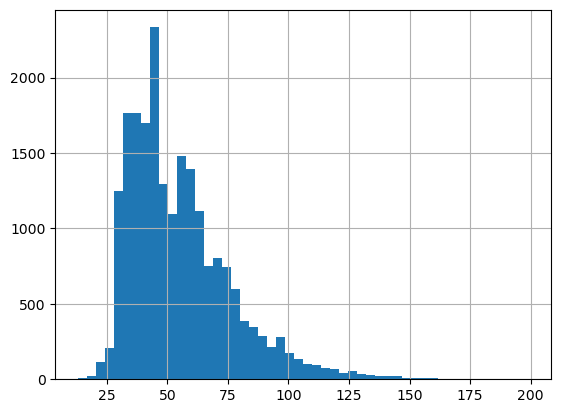

In [80]:
#общая площадь
good_data['total_area'].hist(bins=50)
good_data['total_area'].describe()

count    20888.000000
mean        31.680829
std         14.653484
min          2.000000
25%         18.090000
50%         30.000000
75%         41.000000
max        100.000000
Name: living_area, dtype: float64

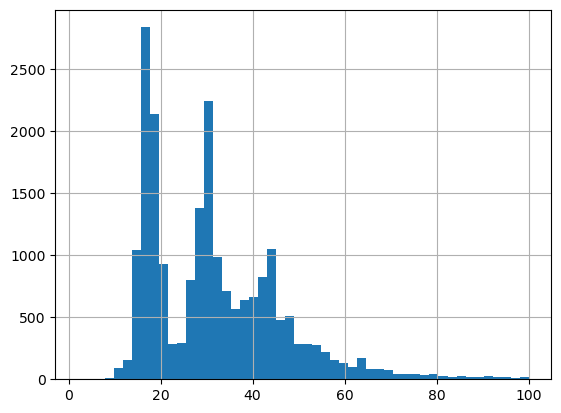

In [81]:
#жилая площадь
good_data['living_area'].hist(bins=50)
good_data['living_area'].describe()

count    20888.000000
mean         9.703824
std          3.654868
min          1.300000
25%          7.100000
50%          9.100000
75%         11.000000
max         30.000000
Name: kitchen_area, dtype: float64

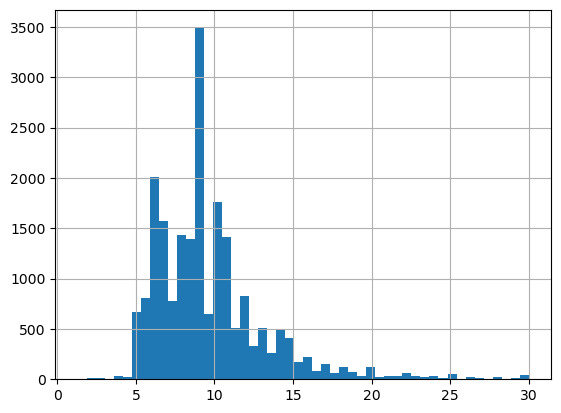

In [82]:
#площадь кухни
good_data['kitchen_area'].hist(bins=50)
good_data['kitchen_area'].describe()

count    20888.000000
mean      5215.525005
std       2989.046267
min        430.000000
25%       3300.000000
50%       4500.000000
75%       6280.000000
max      20000.000000
Name: last_price, dtype: float64

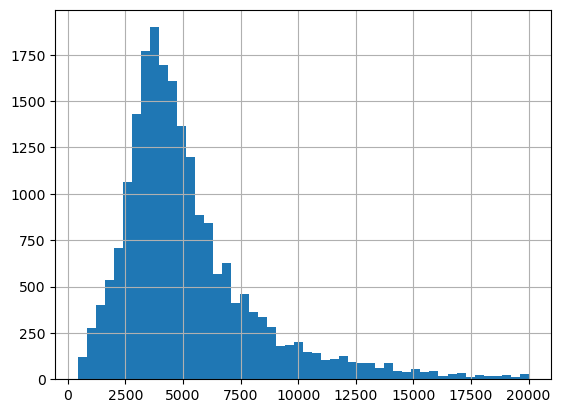

In [83]:
#цена объекта
(good_data['last_price'] / 1000).hist(bins=50) #уменьшим на 1000 для лучшего восприятия цифры
(good_data['last_price'] / 1000).describe()

count    20888.000000
mean         1.979989
std          0.937243
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

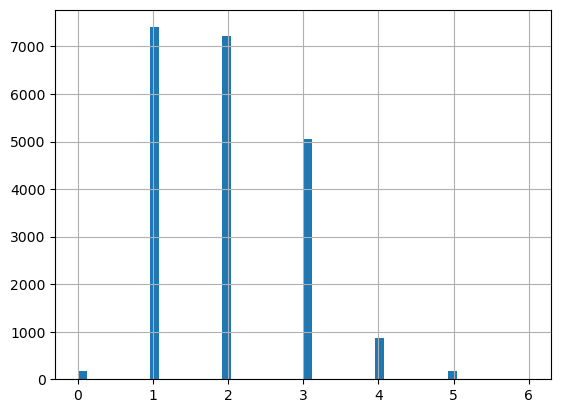

In [84]:
#количество комнат
good_data['rooms'].hist(bins=50)
good_data['rooms'].describe()

count    20888.000000
mean         2.679268
std          0.184573
min          2.200000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.000000
Name: ceiling_height, dtype: float64

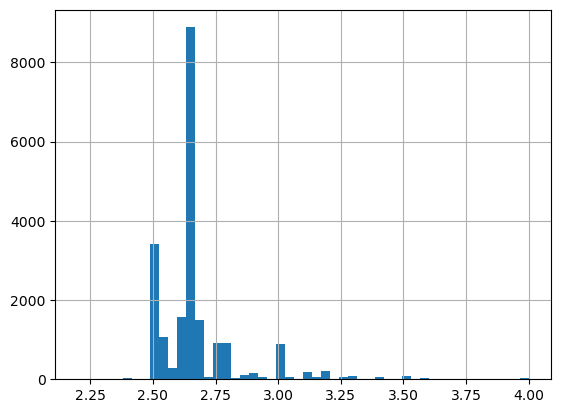

In [85]:
#высота потолков
good_data['ceiling_height'].hist(bins=50)
good_data['ceiling_height'].describe()

count    20888.000000
mean         5.817455
std          4.793305
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         25.000000
Name: floor, dtype: float64

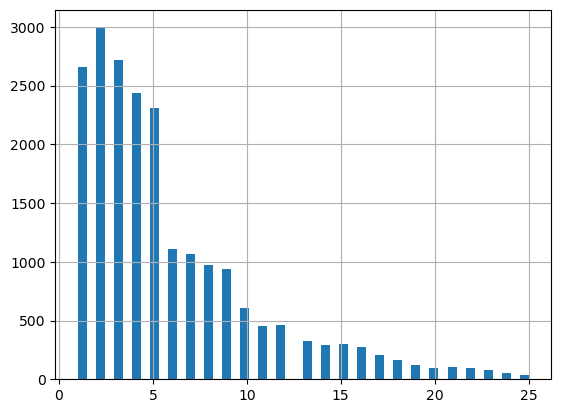

In [86]:
#этаж квартиры
good_data['floor'].hist(bins=50)
good_data['floor'].describe()

count      20888
unique         3
top       другой
freq       15317
Name: floor_type, dtype: object

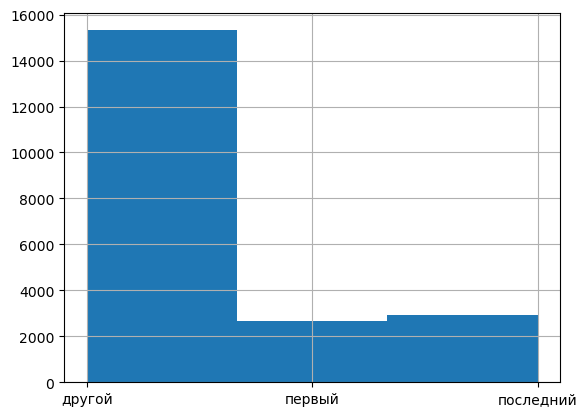

In [87]:
#тип этажа
good_data['floor_type'].hist(bins=3)
good_data['floor_type'].describe()

count    20888.000000
mean        10.661289
std          6.540608
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64

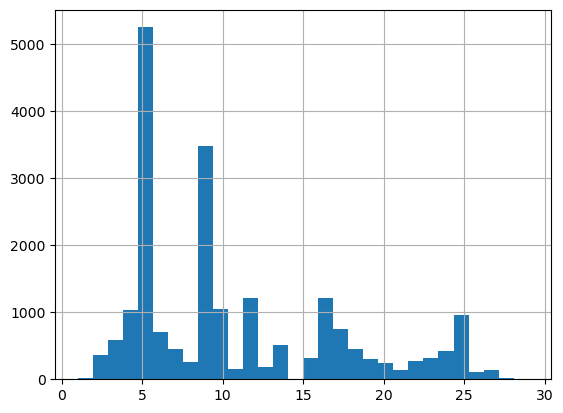

In [88]:
#общее количество этажей
good_data['floors_total'].hist(bins=30)
good_data['floors_total'].describe()

count    16198.000000
mean     14967.981047
std       8524.625436
min        208.000000
25%      10364.000000
50%      13660.000000
75%      17011.500000
max      54926.000000
Name: city_centers_nearest, dtype: float64

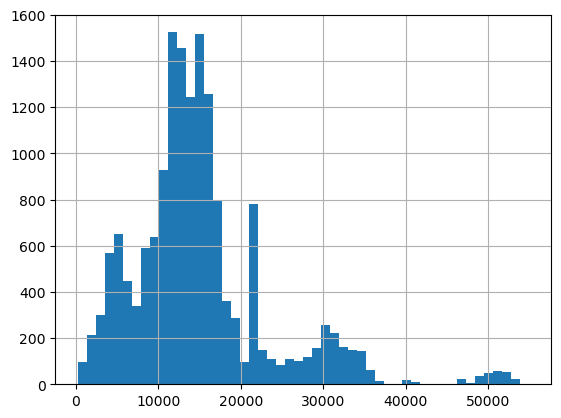

In [89]:
#расстояние до центра города
good_data['city_centers_nearest'].hist(bins=50)
good_data['city_centers_nearest'].describe()

count    16198.000000
mean     29873.046549
std      13261.313130
min          0.000000
25%      18715.000000
50%      27849.000000
75%      39393.000000
max      73827.000000
Name: airports_nearest, dtype: float64

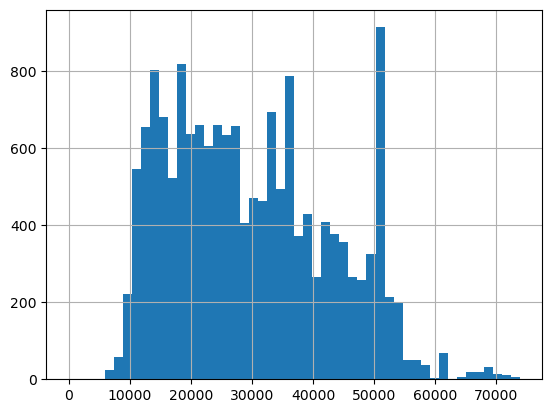

In [90]:
#расстояние до ближайшего аэропорта
good_data['airports_nearest'].hist(bins=50)
good_data['airports_nearest'].describe()

count    15043.000000
mean       441.218141
std        130.350846
min          1.000000
25%        424.000000
50%        460.000000
75%        460.000000
max        749.000000
Name: parks_nearest, dtype: float64

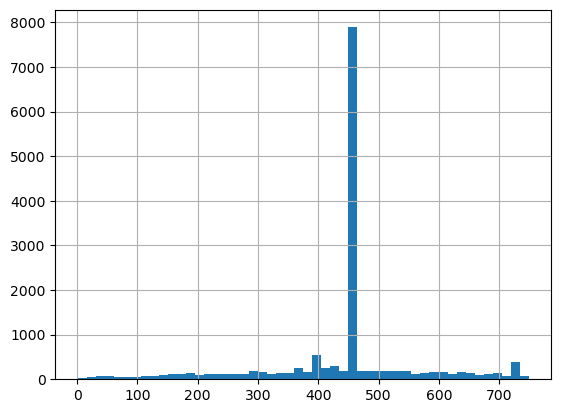

In [91]:
#расстояние до ближайшего парка
good_data['parks_nearest'].hist(bins=50)
good_data['parks_nearest'].describe()

count    20888.00000
mean         6.40157
std          3.48945
min          1.00000
25%          3.00000
50%          6.00000
75%         10.00000
max         12.00000
Name: month, dtype: float64

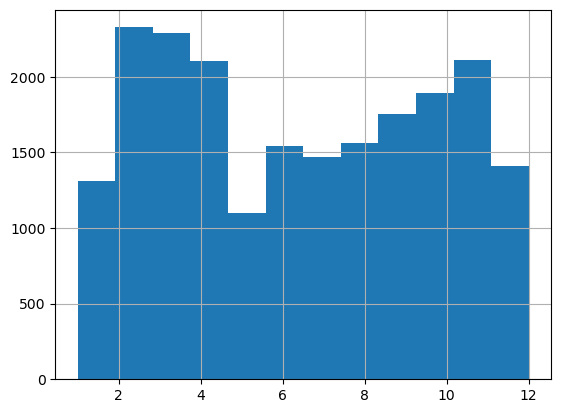

In [92]:
#месяцы
good_data['month'].hist(bins=12)
good_data['month'].describe()

count    20888.000000
mean      2017.433072
std          0.980356
min       2014.000000
25%       2017.000000
50%       2017.000000
75%       2018.000000
max       2019.000000
Name: year, dtype: float64

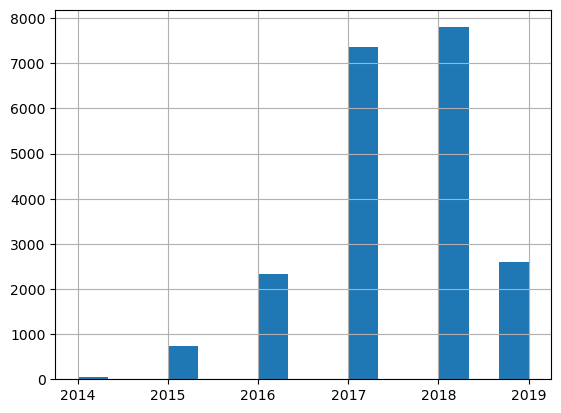

In [93]:
#месяцы
good_data['year'].hist(bins=15)
good_data['year'].describe()

**Общая площадь квартир**   
Средняя площадь квартир около 56 м<sup>2</sup>, медиана чуть меньше - 50 м<sup>2</sup>, что связано с большим количеством небольших квартир. Половина выставленных на продажу квартир имеют площадь от 39 до 66 м<sup>2</sup>.   

**Жилая площадь квартир**   
Средняя жилая площадь квартир около 32 м<sup>2</sup>, медиана чуть меньше - 30 м<sup>2</sup>. На гистограмме мы видим несколько пиков 18, 30 и 42 м<sup>2</sup>, что вероятно связано с типовыми проектными решениями при строительстве квартир.  

**Площадь кухни**   
Средняя площадь кухни около 9 м<sup>2</sup> (среднее и медиана практически равны). Половина выставленных на продажу квартир имеют площадь кухни от 7 до 11 м<sup>2</sup> (так же стандартное проектное решение при строительстве квартир).   

**Цена объекта**   
Средняя цена объекта около 5,2 млн, медиана 4,5 млн, что достаточно логично, потому что дорогого жилья продается гораздо меньше, поэтому медиана смещена в меньшую сторону, где находится большинство объявлений. Распределение цен выглядит практически как нормальное. Половина выставленных на продажу квартир имеют стоимость от 3,3 до 6,3 млн.    

**Количество комнат**
Больше всего продают 1-, 2- и 3-х комнатные квартиры. Это связано с их большей распространенностью при типовом строительстве домов.    

**Высота потолков**
Самая частая высота потолков 2,65 м - это наиболее частый стандарт высоты при строительстве домов. Есть пики на 2,5 и 2,75 м. Встречаются редкие случаи, где высота потолков более 3 метров. Скорее свего это дома сталинской постройки.    

**Этаж квартиры**
На графике видно несколько групп с 1 по 5 этаж, с 5 по 10 и больше 10.   
Чаще всего продают квартиры на этажах с 1 по 5 этажи, а среди этой подгруппы самые частые продажи на 2 этаже.   
С 5 по 10 этаж квартиры продают практически в 2 раза реже (этих домов в целом меньше).   
В подгруппе больше 10 этажа квартир становится все меньше и меньше. Интересная особенность: квартиры на 13 этаже практически не продают.   

**Тип этажа**   
Почти 75% квартир имеют тип этажа **"другой"**. Квартиры на **"первом"** и на **"последнем"** этажах продают практически одинаково часто.    

**Общее количество этажей**   
Среднее количество этажей 10, медиана 9. При этом мы видим несколько пиков, чаще всего покупают квартиры в домах, где 5 этажей, затем 9. Это 2 самых частых варианта постройки многоквартирных домов в России. Также есть пики 12, 17 и 25 этажей.   

**Расстояние до центра города**   
Среднее расстояние до центра города около 15 км, медиана 13,6 км. Половина домов из объявлений находятся на расстоянии от 10 до 17 км от центра города. Пики на 22, 30, 40 и 50 км вероятно связаны с тем, что там расположены крупные микрорайоны или другие населенные пункты.   

**Расстояние до ближайшего аэропорта**
Среднее расстояние до аэропорта 29,8 км, медиана 27,8 км. Однако самое частое расположение от эаропорта 50 км, вероятно эта большое количество объявлений из Санкт-Петербурга.    

**Расстояние до ближайшего парка**   
Почти в половине всех объявлений расстояние до ближайшего парка 450 м, что очень здорово, парк в пешей доступности. Остальные значения встречаются гораздо реже.    

**Месяц**  
К весне и лету отмечается некоторый спад продаж.   

**Год**   
C каждым годом объявлений становится все больше. Видимо это связано с развитием самого сервиса. А в 2019г представлены данные не за весь год (вероятнее всего зависит от даты выгрузки датасета), либо с сервисом что-то не так, клиенты уходят.  
 



#### Как быстро продавались квартиры 

45    845
60    501
7     219
30    193
4     166
Name: days_exposition, dtype: Int64
count    18158.000000
mean       152.827900
std        162.968503
min          1.000000
25%         43.000000
50%         90.000000
75%        206.000000
max        800.000000
Name: days_exposition, dtype: float64


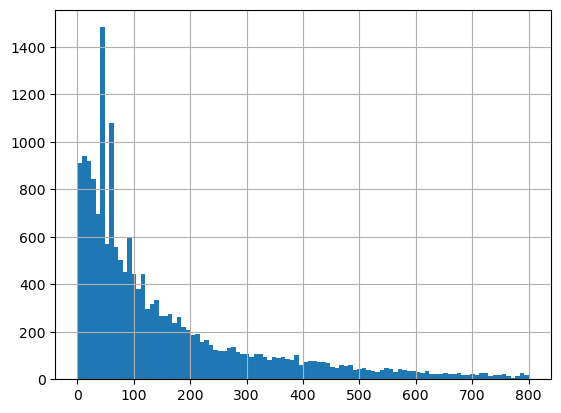

In [94]:
good_data['days_exposition'].hist(bins=100)
print(good_data['days_exposition'].value_counts().head())
print(good_data['days_exposition'].describe())

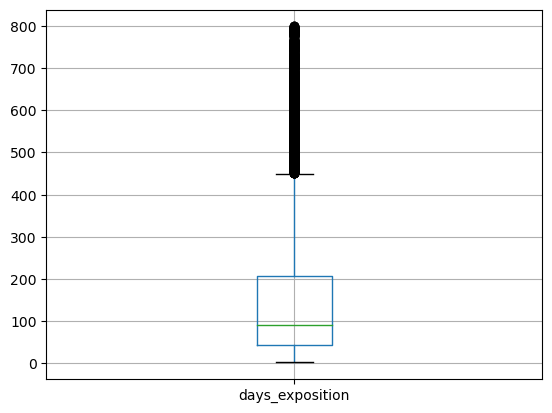

In [95]:
good_data.boxplot(column='days_exposition');

Среднее количество дней, за которое продавалась квартира, 153 дня. Медиана 90 дней. Пуассоновское распределение значений. Видны очень яркие пики на 45, 60, 90 днях, это очень похоже на какие-то стандартные значения (возможно объявление автоматически удалялось в архив, или заканчивалось платное размещение объявления).    
Половина объявлений закрывалось в период от 43 до 206 дней.
Очень долгим объявление можно считать примерно после 450 дней размещения. Все быстрые продажи укладывались в "ус" боксплота и значимых выбросов не было. Поэтому все что меньше 43 дней можно считать достаточно быстрым. 

#### От чего зависит цена? 
Оценим корреляцию цены со всеми данными, а затем подробно изучим взаимосвязь с:   
- общей площадью;
- жилой площадью;
- площадью кухни;
- количеством комнат;
- этажом, на котором расположена квартира (первый, последний, другой);
- датой размещения (день недели, месяц, год).

In [96]:
good_data.corr()['last_price'].sort_values(ascending=False)

last_price                 1.000000
total_area                 0.756648
sq_meter_price             0.659551
living_area                0.629170
kitchen_area               0.521046
rooms                      0.480887
ceiling_height             0.404697
parks_around3000           0.177650
total_images               0.165307
floors_total               0.144027
ponds_around3000           0.114722
floor                      0.109165
days_exposition            0.082746
balcony                    0.061003
is_apartment               0.017864
ponds_nearest              0.008579
month                      0.004413
year                       0.001216
week_day                  -0.016079
parks_nearest             -0.016984
open_plan                 -0.039937
studio                    -0.058727
airports_nearest          -0.081517
city_centers_nearest      -0.364126
city_centers_nearest_km   -0.364995
Name: last_price, dtype: float64

Мы видим явную положительную корреляционную связь цены с общей площадью, ценой квадратного метра, жилой площадью, площадью кухни и количеством комнат (но уже гораздо слабее), а также отрицательную связь с расстоянием до центра города.

Построим графики зависимости цены от выбранных параметров

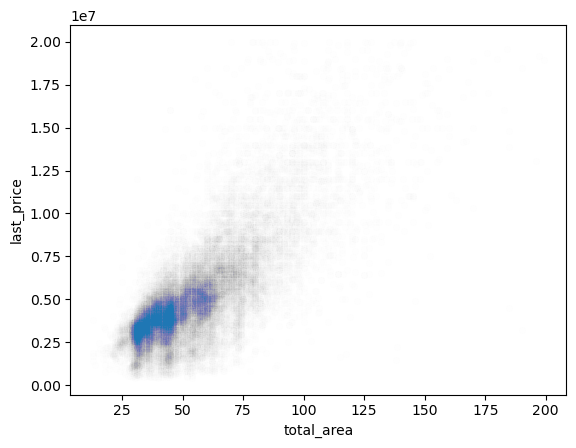

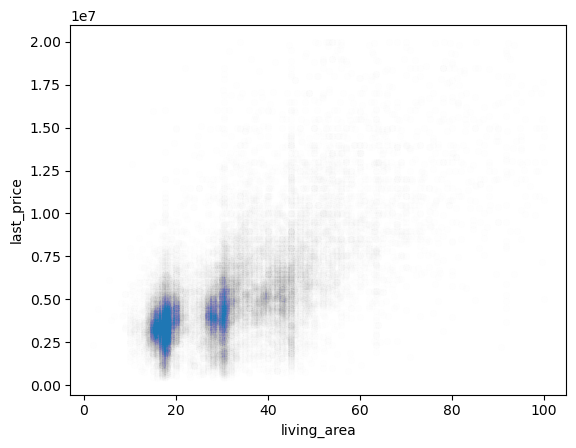

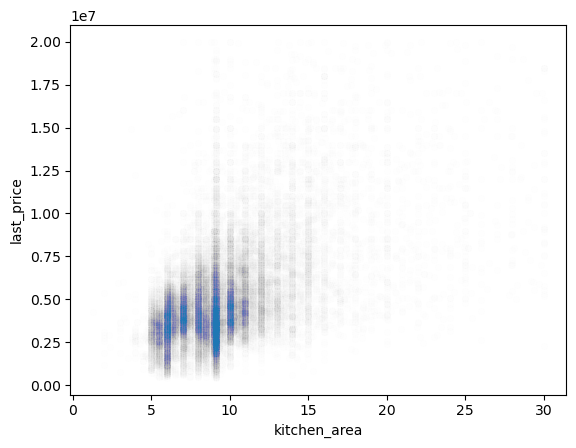

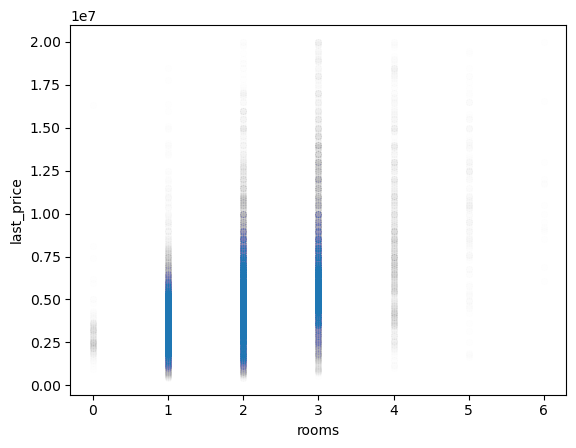

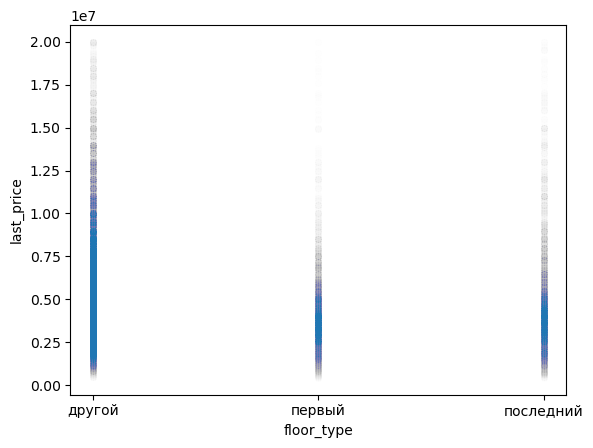

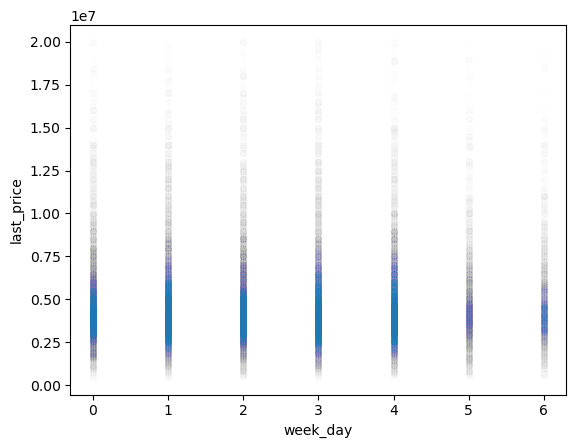

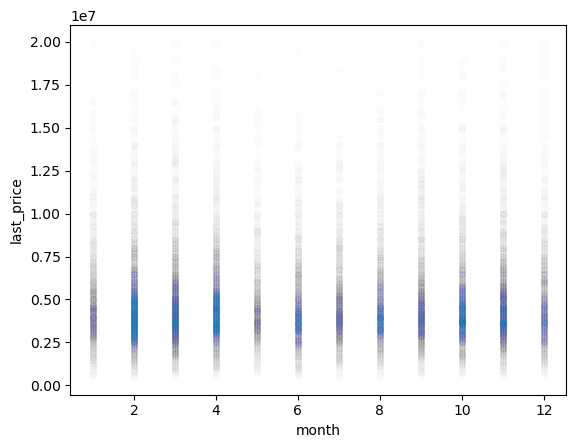

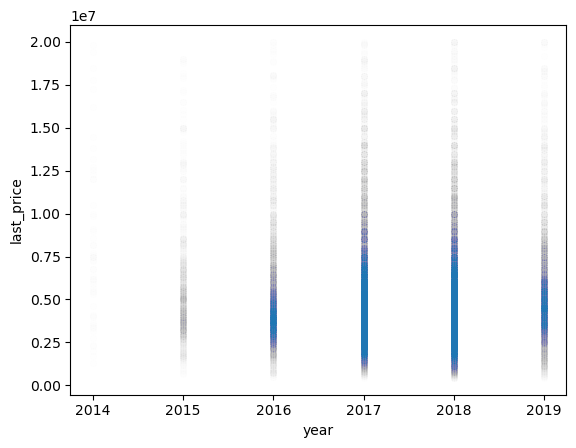

In [97]:
column_list = ['total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type', 'week_day', 'month', 'year']
for i in column_list:
    good_data.plot(x=i, y='last_price', kind='scatter', alpha=0.005)

Полученные графики подтверждают рассчитанные цифровые данные корреляции. 
- с общей площадью квартиры отмечается самая лучшая корреляция, затем с жилой площадью и площадью кухни
- с количеством комнат отмечается взаимосвязь, однако если в квртире более 3 комнат, то связь пропадает (возможно нелинейная зависимость)
- взаимосвязь с типом этажа имеет нелинейную форму (парабола ветви вниз), если провести аналогию первый - 1, другой - 2, последний - 3. Первый и последний этажи дешевле
- с днем недели и месяцем зависимости никакой нет. В любой месяц и день недели цены остаются приблизительно одинаковыми.
- с годом подачи объявления также нет никакой связи, при этом мы видим, что свежих объявлений больше.

#### Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [98]:
data.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
Санкт-Петербург,15721,5500000.0
Мурино,590,3400000.0
Кудрово,472,3890000.0
поселок Шушары,440,3950000.0
Всеволожск,398,3450000.0
Пушкин,369,5180000.0
Колпино,338,3600000.0
поселок Парголово,327,4100000.0
Гатчина,307,3100000.0


In [99]:
print('Средняя цена квадратного метра в ТОП-10 районах по количеству объявлений:', (good_data.pivot_table(index='locality_name', values='sq_meter_price', aggfunc='mean')
 .sort_values(by='sq_meter_price', ascending=False).head(10))['sq_meter_price'].mean().round(1), 'рублей.')

Средняя цена квадратного метра в ТОП-10 районах по количеству объявлений: 101055.4 рублей.


Топ-10 населенных пунктов с самым дорогим жильем

In [100]:
(good_data.pivot_table(index='locality_name', values='sq_meter_price', aggfunc='mean')
 .sort_values(by='sq_meter_price', ascending=False).head(10))

,sq_meter_price
locality_name,
Зеленогорск,114732.039059
поселок Лисий Нос,113728.34873
Санкт-Петербург,108212.308719
Сестрорецк,102052.350788
Пушкин,101480.874582
деревня Мистолово,98549.976709
поселок Левашово,96997.690531
Кудрово,95401.428749
поселок Парголово,90056.561011


**Самые дорогие квартиры не в Санкт-Петербурге! Даже в поселке Лисий Нос дороже!**

Топ-10 населенных пунктов с самым дешевым жильем

In [101]:
(good_data.pivot_table(index='locality_name', values='sq_meter_price', aggfunc='mean')
.sort_values(by='sq_meter_price', ascending=False).tail(10))

,sq_meter_price
locality_name,
поселок Почап,16037.735849
поселок станции Лужайка,15000.0
поселок Житково,14956.275202
деревня Ям-Тесово,13711.553373
деревня Сижно,13709.677419
поселок Тёсово-4,12931.034483
поселок Совхозный,12629.129129
деревня Выскатка,12335.480902
деревня Вахнова Кара,11688.311688


Самое дешевое жилье в деревне Старополье. 11 тыс. рублей за м<sup>2</sup>!

#### Рассчитаем цену 1 километра в Санкт-Петербурге.

In [102]:
print('Средняя цена 1 км в Санкт-Петербурге равна', 
      (good_data.loc[good_data['locality_name'] == 'Санкт-Петербург', 'last_price'].mean() /
       good_data.loc[good_data['locality_name'] == 'Санкт-Петербург', 'city_centers_nearest_km']
       .mean()).round(1), 'рублей.')
print('Корреляция между ценой и расстоянием до центра города в километрах в Санкт-Петербурге', 
      (good_data.loc[good_data['locality_name'] == 'Санкт-Петербург', 'last_price']
       .astype('float').corr(good_data.loc[good_data['locality_name'] == 'Санкт-Петербург', 'city_centers_nearest_km']))
       .round(2))
print('Корреляция между ценой и расстоянием до центра города в километрах общая', 
      good_data['last_price'].astype('float').corr(good_data['city_centers_nearest_km']).round(2))


Средняя цена 1 км в Санкт-Петербурге равна 520941.0 рублей.
Корреляция между ценой и расстоянием до центра города в километрах в Санкт-Петербурге -0.39
Корреляция между ценой и расстоянием до центра города в километрах общая -0.36


Мы обнаружили очень интересную закономерность - выявляется отрицательная корреляционная зависимость! Цена квартиры уменьшается при увеличении расстояния до центра города.

,city_centers_nearest_km,last_price
0,0.0,9261818.2
1,1.0,10022560.0
2,2.0,9532413.1
3,3.0,8522181.2
4,4.0,8910037.6
5,5.0,9097732.7
6,6.0,8189793.6
7,7.0,7809329.9
8,8.0,7507117.9
9,9.0,6102929.9


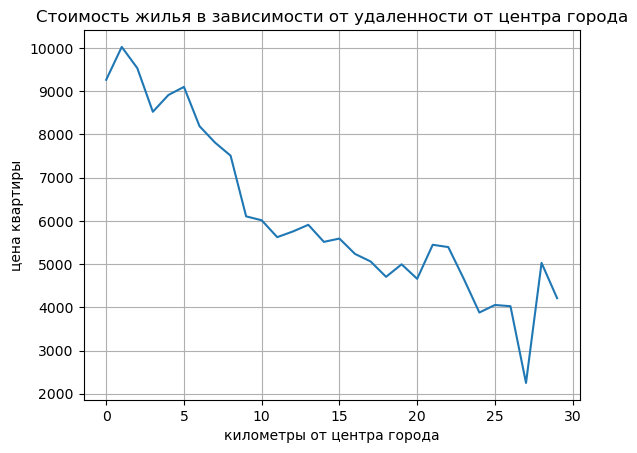

In [105]:
good_data_spb = good_data.query('locality_name == "Санкт-Петербург"')
# pivot_table не поддерживает Int64, заменим на int
good_data_spb['last_price'] = good_data_spb['last_price'].astype('int')
spb_km_price = good_data_spb.pivot_table(index='city_centers_nearest_km', values='last_price', aggfunc='mean')['last_price'].astype('float64').round(1).reset_index()
# spb_km_price = good_data_spb.pivot_table(index='city_centers_nearest_km', values='last_price', aggfunc='mean')['last_price'].round(1).reset_index()

display(spb_km_price)
spb_km_price['last_price'] = spb_km_price['last_price'] / 1000 # уменьшим цену на 1000 для простоты восприятия
spb_km_price.plot(x='city_centers_nearest_km', y='last_price', grid=True, 
                  title='Стоимость жилья в зависимости от удаленности от центра города',
                  xlabel='километры от центра города',
                  ylabel='цена квартиры',
                  legend=False);

**Видим четкую зависимость: чем дальше от центра города, тем дешевле жилье!**

### Общий вывод   
В ходе проведенного исследования мы выполнили:
- избавились от части пропусков. Пропуски возникали как в данных от пользователей, так и из картографических сервисов (эту часть пропусков можно заполнить, запросив информацию у заказчика).
- заменили типы данных. Нам необходимо было изменить типы данных, чтобы дальнейшие рассчеты с целыми числами были правильными, тип `datetime` необходим для возможности работы с датой и временем.
- избавились от неявных дубликатов в столбце с названиями населенных пунктов (было не легко).
- очистили данные от выбросов и явных ошибок.   

Анализ данных показал, что большинство объявлений описывают типовые варианты квартир и домов, построенных в советское время.
- Средняя площадь квартир около 56 м<sup>2</sup>.
- Средняя жилая площадь квартир около 32 м<sup>2</sup>. 
- Средняя площадь кухни около 9 м<sup>2</sup>. 
- Средняя цена объекта около 5,2 млн, медиана 4,5 млн.
- Больше всего продают 1-, 2- и 3-х комнатные квартиры. 
- Самая частая высота потолков 2,65 м - это наиболее частый стандарт высоты при строительстве домов. Есть пики на 2,5 и 2,75 м. 
- Этаж квартиры На графике видно несколько групп с 1 по 5 этаж, с 5 по 10 и больше 10.Чаще всего продают квартиры на этажах с 1 по 5 этажи, а среди этой подгруппы самые частые продажи на 2 этаже. С 5 по 10 этаж квартиры продают практически в 2 раза реже (этих домов в целом меньше). В подгруппе больше 10 этажа квартир становится все меньше и меньше. Интересная особенность: квартиры на 13 этаже практически не продают.
- Почти 75% квартир имеют тип этажа "другой". Квартиры на "первом" и на "последнем" этажах продают практически одинаково часто.
- Среднее количество этажей 10, медиана 9. При этом мы видим несколько пиков, чаще всего покупают квартиры в домах, где 5 этажей, затем 9. Это 2 самых частых варианта постройки многоквартирных домов в России. Также есть пики 12, 17 и 25 этажей.
- Среднее расстояние до центра города около 15 км, медиана 13,6 км. 
- Среднее расстояние до аэропорта 29,8 км, медиана 27,8 км. 
- Почти в половине всех объявлений расстояние до ближайшего парка 450 м, что очень здорово, парк в пешей доступности. 
- Среднее количество дней, за которое продавалась квартира, 153 дня. Медиана 90 дней. Пуассоновское распределение значений. Видны очень яркие пики на 45, 60, 90 днях, это очень похоже на какие-то стандартные значения (возможно объявление автоматически удалялось в архив или заканчивалось платное размещение объявления, нужно уточнить у заказчика).
- Половина объявлений закрывалось в период от 43 до 206 дней. Очень долгим объявление можно считать примерно после 450 дней размещения. Все продажи ранее 43 дней можно считать достаточно быстрыми.   

При рассчете взаимосвязей параметров мы обнаружили явную положительную корреляционную связь цены квартиры с общей площадью, ценой квадратного метра, жилой площадью, площадью кухни и количеством комнат(но уже гораздо слабее), а также отрицательную связь с расстоянием до центра города.
Построенные графики корреляции подтверждают рассчитанные цифровые данные.   
- с общей площадью квартиры отмечается самая лучшая корреляция, затем с жилой площадью и площадью кухни.   
- с количеством комнат отмечается взаимосвязь, однако если в квртире более 3 комнат, то связь пропадает (возможно нелинейная зависимость)
- взаимосвязь с типом этажа имеет нелинейную форму (парабола ветви вниз), если провести аналогию первый - 1, другой - 2, последний - 3. Первый и последний этажи дешевле.
- с днем недели и месяцем зависимости никакой нет. В любой месяц и день недели цены остаются приблизительно одинаковыми.
- с годом подачи объявления также нет никакой связи, при этом мы видим, что свежих объявлений больше.   
Самые дорогие квартиры оказались в Зеленогорске, поселке Лисий Нос, а Санкт-Петербург лишь на 3 месте.   
Мы обнаружили очень интересную закономерность - выявляется отрицательная корреляционная зависимость! Цена квартиры уменьшается при увеличении расстояния до центра города.   

В целом, если рассматривать полученные результаты, то в автоматическую систему оценки рыночной стоимости квартиры скорее всего войдут следующие параметры: 
- общая площадь 
- жилая площадь
- площадь кухни 
- количество комнат
- расстояние до центра города.